# 2012 Federal Election Commission Database

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\onwoc\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\onwoc\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
fec = pd.read_csv("P00000001-ALL.csv", low_memory=False)

In [3]:
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [5]:
fec.iloc[56]

cmte_id                       C00410118
cand_id                       P20002978
cand_nm              Bachmann, Michelle
contbr_nm               KINCAID, THOMAS
contbr_city                   CALISTOGA
contbr_st                            CA
contbr_zip                    945151255
contbr_employer                    NONE
contbr_occupation               RETIRED
contb_receipt_amt                 250.0
contb_receipt_dt              27-JUN-11
receipt_desc                        NaN
memo_cd                             NaN
memo_text                           NaN
form_tp                           SA17A
file_num                         736166
Name: 56, dtype: object

there are no political party affiliations in the data, so this would be
useful to add. You can get a list of all the unique political candidates using unique

In [6]:
unique_cands = fec["cand_nm"].unique()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [7]:
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [8]:
#One way to indicate party affiliation is using a dictionary

parties = {"Bachmann, Michelle": "Republican",
"Cain, Herman": "Republican",
"Gingrich, Newt": "Republican",
"Huntsman, Jon": "Republican",
"Johnson, Gary Earl": "Republican",
"McCotter, Thaddeus G": "Republican",
"Obama, Barack": "Democrat",
"Paul, Ron": "Republican",
"Pawlenty, Timothy": "Republican",
"Perry, Rick": "Republican",
"Roemer, Charles E. 'Buddy' III": "Republican",
"Romney, Mitt": "Republican",
"Santorum, Rick": "Republican"}

Now, using this mapping and the map method on Series objects, you can compute an
array of political parties from the candidate names

In [9]:
#Add it as a column
fec["party"] = fec["cand_nm"].map(parties)

fec["party"].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

Donations by occupation and employer is another oft-studied statistic. For example, attorneys tend
to donate more money to Democrats, while business executives tend to donate more
to Republicans.

In [21]:
fec = fec[fec["contb_receipt_amt"] > 0]

fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

In [22]:
fec["contbr_occupation"].value_counts()[:10]

contbr_occupation
RETIRED         233990
NOT PROVIDED     57151
ATTORNEY         34286
HOMEMAKER        29931
PHYSICIAN        23432
ENGINEER         14334
TEACHER          13990
CONSULTANT       13273
PROFESSOR        12555
NOT EMPLOYED      9828
Name: count, dtype: int64

You will notice by looking at the occupations that many refer to the same basic job
type, or there are several variants of the same thing. The following code snippet
illustrates a technique for cleaning up a few of them by mapping from one occupation
to another; note the “trick” of using dict.get to allow occupations with no mapping
to “pass through”

In [23]:
occ_mapping = {
"INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
"INFORMATION REQUESTED" : "NOT PROVIDED",
"INFORMATION REQUESTED (BEST EFFORTS)" : "NOT PROVIDED",
"C.E.O.": "CEO"
}

In [24]:
def get_occ(x):
    # If no mapping provided, return x
    return occ_mapping.get(x, x)

In [25]:
fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [26]:
emp_mapping = {
"INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
"INFORMATION REQUESTED" : "NOT PROVIDED",
"SELF" : "SELF-EMPLOYED",
"SELF EMPLOYED" : "SELF-EMPLOYED",
}
def get_emp(x):
    # If no mapping provided, return x
    return emp_mapping.get(x, x)

In [27]:
fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

Now, you can use pivot_table to aggregate the data by party and occupation, then
filter down to the subset that donated at least $2 million overall

In [28]:
by_occupation = fec.pivot_table("contb_receipt_amt", index="contbr_occupation", columns="party", aggfunc="sum")

over_2mm = by_occupation[by_occupation.sum(axis="columns") > 2000000]

over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


<AxesSubplot:ylabel='contbr_occupation'>

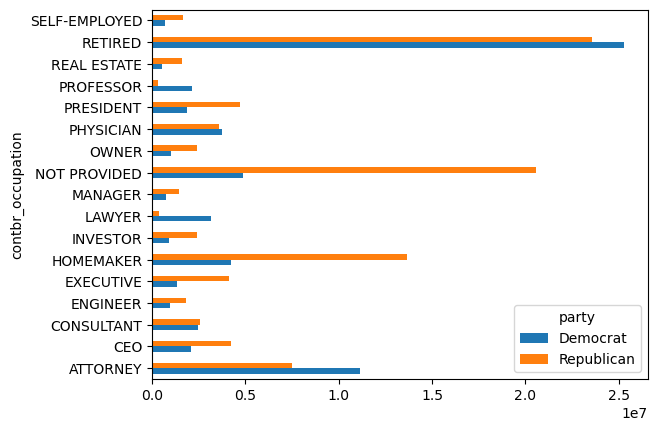

In [29]:
over_2mm.plot(kind="barh")

You might be interested in the top donor occupations or top companies that donated
to Obama and Romney

In [30]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)["contb_receipt_amt"].sum()
    return totals.nlargest(n)

Then aggregate by occupation and employer

In [31]:
grouped = fec_mrbo.groupby("cand_nm")

grouped.apply(get_top_amounts, "contbr_occupation", n=7)

cand_nm        contbr_occupation
Obama, Barack  RETIRED              25305116.38
               ATTORNEY             11141982.97
               NOT PROVIDED          4866973.96
               HOMEMAKER             4248875.80
               PHYSICIAN             3735124.94
               LAWYER                3160478.87
               CONSULTANT            2459912.71
Romney, Mitt   RETIRED              11508473.59
               NOT PROVIDED         11396894.84
               HOMEMAKER             8147446.22
               ATTORNEY              5364718.82
               PRESIDENT             2491244.89
               CEO                   2324297.03
               EXECUTIVE             2300947.03
Name: contb_receipt_amt, dtype: float64

In [32]:
grouped.apply(get_top_amounts, "contbr_employer", n=10)

cand_nm        contbr_employer   
Obama, Barack  RETIRED               22694358.85
               SELF-EMPLOYED         18626807.16
               NOT EMPLOYED           8586308.70
               NOT PROVIDED           5053480.37
               HOMEMAKER              2605408.54
               STUDENT                 318831.45
               VOLUNTEER               257104.00
               MICROSOFT               215585.36
               SIDLEY AUSTIN LLP       168254.00
               REFUSED                 149516.07
Romney, Mitt   NOT PROVIDED          12059527.24
               RETIRED               11506225.71
               HOMEMAKER              8147196.22
               SELF-EMPLOYED          7414115.22
               STUDENT                 496490.94
               CREDIT SUISSE           281150.00
               MORGAN STANLEY          267266.00
               GOLDMAN SACH & CO.      238250.00
               BARCLAYS CAPITAL        162750.00
               H.I.G. CAPITAL      

A useful way to analyze this data is to use the cut function to discretize the contributor
amounts into buckets by contribution size

In [33]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100_000, 1_000_000, 10_000_000])

labels = pd.cut(fec_mrbo["contb_receipt_amt"], bins)
labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

We can then group the data for Obama and Romney by name and bin label to get a
histogram by donation size

In [34]:
grouped = fec_mrbo.groupby(["cand_nm", labels])

grouped.size().unstack(level=0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


This data shows that Obama received a significantly larger number of small donations
than Romney. You can also sum the contribution amounts and normalize within
buckets to visualize the percentage of total donations of each size by candidate

In [35]:
bucket_sums = grouped["contb_receipt_amt"].sum().unstack(level=0)

normed_sums = bucket_sums.div(bucket_sums.sum(axis="columns"), axis="index")

normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<AxesSubplot:ylabel='contb_receipt_amt'>

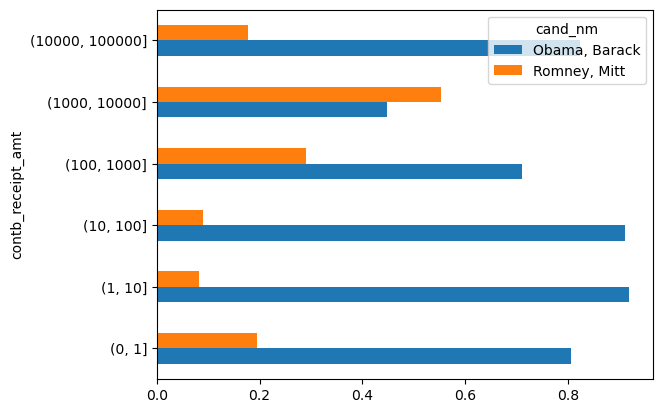

In [36]:
normed_sums[:-2].plot(kind="barh")

We can start by aggregating the data by candidate and state

In [37]:
grouped = fec_mrbo.groupby(["cand_nm", "contbr_st"])

totals = grouped["contb_receipt_amt"].sum().unstack(level=0).fillna(0)

totals = totals[totals.sum(axis="columns") > 100000]

totals.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


If you divide each row by the total contribution amount, you get the relative percentage
of total donations by state for each candidate

In [38]:
percent = totals.div(totals.sum(axis="columns"), axis="index")

In [39]:
percent.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
